<a href="https://colab.research.google.com/github/Sopralapanca/Pattern-Recognition/blob/main/ASSIGNMENT_4_GIACOMO_CARF%C3%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ASSIGNMENT_4_GIACOMO_CARFì**


All the image processing assignments require to use the following dataset:

http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip

The dataset includes original images as well as their semantic segmentation in 9 object classes (i.e. the image files whose name ends  in “_GT”, where each pixel has a value which is the identifier of the semantic class associated to it).  Each file has a name starting with a number from 1 to 8, which indicates the thematic subset of the image, followed by the rest of the file name. This tematic subset can be used for instance as a class for the full image in image classification tasks.


Perform image segmentation on all images in the dataset, using the normalized cut algorithm running on the top of superpixels rather than on raw pixels. For each image compute an accuracy metric (which one it is up to you to decide) measuring the overlap between the image segments identified by NCUT and the ground truth semantic segmentation. Provide a table summarizing the average accuracy on all images (for the different visual classes), plus present 2 examples of images that are well-segmented (according to the above defined metric).

Hint: in Python, you have an NCut implementation in the scikit-image library; in Matlab, you can use the original NCut implementation here. Superpixels are implemented both in Matlab as well as in OpenCV. Feel free to pickup the implementation you liked most (and motivate the choice).

In [1]:
%%capture
!pip install networkx==2.8

# Useful packages

In [2]:
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np
from matplotlib.pyplot import figure

# Loading the dataset

In [3]:
%%capture
!git clone https://github.com/Sopralapanca/Pattern-Recognition.git

In [4]:
%%capture
!unzip "/content/Pattern-Recognition/dataset/msrc_objcategimagedatabase_v1.zip" -d "/content/Pattern-Recognition/dataset/"

# Plot one normal image and one segmented image from the dataset

In [5]:
data_path = "/content/Pattern-Recognition/dataset/MSRC_ObjCategImageDatabase_v1"
images_names = []
for file in sorted(os.listdir(data_path)):
    if file.endswith(".bmp"):
        images_names.append(file)

print(images_names)

['1_10_s.bmp', '1_10_s_GT.bmp', '1_11_s.bmp', '1_11_s_GT.bmp', '1_12_s.bmp', '1_12_s_GT.bmp', '1_13_s.bmp', '1_13_s_GT.bmp', '1_14_s.bmp', '1_14_s_GT.bmp', '1_15_s.bmp', '1_15_s_GT.bmp', '1_16_s.bmp', '1_16_s_GT.bmp', '1_17_s.bmp', '1_17_s_GT.bmp', '1_18_s.bmp', '1_18_s_GT.bmp', '1_19_s.bmp', '1_19_s_GT.bmp', '1_1_s.bmp', '1_1_s_GT.bmp', '1_20_s.bmp', '1_20_s_GT.bmp', '1_21_s.bmp', '1_21_s_GT.bmp', '1_22_s.bmp', '1_22_s_GT.bmp', '1_23_s.bmp', '1_23_s_GT.bmp', '1_24_s.bmp', '1_24_s_GT.bmp', '1_25_s.bmp', '1_25_s_GT.bmp', '1_26_s.bmp', '1_26_s_GT.bmp', '1_27_s.bmp', '1_27_s_GT.bmp', '1_28_s.bmp', '1_28_s_GT.bmp', '1_29_s.bmp', '1_29_s_GT.bmp', '1_2_s.bmp', '1_2_s_GT.bmp', '1_30_s.bmp', '1_30_s_GT.bmp', '1_3_s.bmp', '1_3_s_GT.bmp', '1_4_s.bmp', '1_4_s_GT.bmp', '1_5_s.bmp', '1_5_s_GT.bmp', '1_6_s.bmp', '1_6_s_GT.bmp', '1_7_s.bmp', '1_7_s_GT.bmp', '1_8_s.bmp', '1_8_s_GT.bmp', '1_9_s.bmp', '1_9_s_GT.bmp', '2_10_s.bmp', '2_10_s_GT.bmp', '2_11_s.bmp', '2_11_s_GT.bmp', '2_12_s.bmp', '2_12_s_GT.

In [6]:
def load_image(path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  return img

Text(0.5, 1.0, 'Groundtruth Segmented')

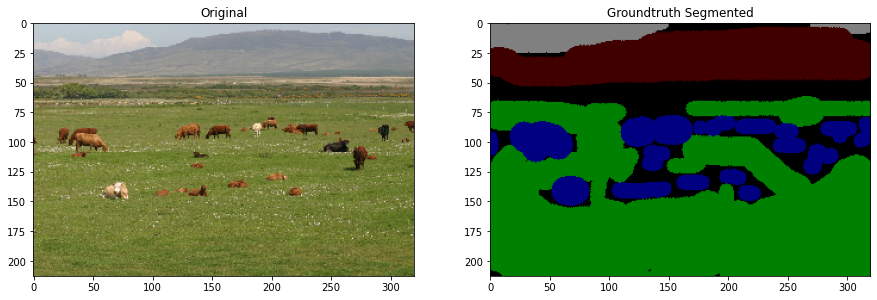

In [7]:
img_normal = load_image(data_path+"/"+images_names[0])
img_segmented = load_image(data_path+"/"+images_names[1])

f, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

axarr[0].imshow(img_normal)
axarr[0].set_title("Original")
axarr[1].imshow(img_segmented)
axarr[1].set_title("Groundtruth Segmented")

# Collect all the colors of the classes of the segmented images


In [8]:
#The values from these constants have been taken from the file .html in the dataset
VOID      = (0, np.array([0,0,0]),        "VOID")
BUILDING  = (1, np.array([128,0,0]),      "BUILDING")
GRASS     = (2, np.array([0,128,0]),      "GRASS")
TREE      = (3, np.array([128,128,0]),    "TREE")
COW       = (4, np.array([0,0,128]),      "COW")
HORSE     = (5, np.array([128,0,128]),    "HORSE")
SHEEP     = (6, np.array([0,128,128]),    "SHEEP")
SKY       = (7, np.array([128,128,128]),  "SKY")
MOUNTAIN  = (8, np.array([64,0,0]),       "MOUNTAIN")
AEROPLANE = (9, np.array([192,0,0]),      "AEROPLANE")
WATER     = (10, np.array([64,128,0]),    "WATER")
FACE      = (11, np.array([192,128,0]),   "FACE")
CAR       = (12, np.array([64,0,128]),    "CAR")
BICYCLE   = (13, np.array([192,0,128]),   "BICYCLE")

object_classes = [VOID,   BUILDING,   GRASS,  TREE,     COW,
                  HORSE,  SHEEP,      SKY,    MOUNTAIN, AEROPLANE,
                  WATER,  FACE,       CAR,    BICYCLE ]


# Show example of an image with superpixel and segmentation side by side

use SLIC for computing superpixels

REF: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html

SLIC - K-Means based image segmentation

This algorithm simply performs K-means in the 5d space of color information and image location and is therefore closely related to quickshift. As the clustering method is simpler, it is very efficient. It is essential for this algorithm to work in Lab color space to obtain good results.

The compactness parameter trades off color-similarity and proximity, while n_segments chooses the number of centers for kmeans.

In [9]:
def compute_superpixels(img, compactness=30, n_segments=100):
  labels = segmentation.slic(img, compactness=compactness, n_segments=n_segments, enforce_connectivity=True)
  image = segmentation.mark_boundaries(img, labels, color=(0, 0, 0))
  image = img_as_ubyte(image)
  pixel_labels = color.label2rgb(labels, img, kind='avg', bg_label=0)
  return image, labels, pixel_labels

In [10]:
def apply_ncut(img, labels):
  # using the labels found with the superpixeled image
  # compute the Region Adjacency Graph using mean colors
  g = graph.rag_mean_color(img, labels, mode='similarity')

  # perform Normalized Graph cut on the Region Adjacency Graph
  labels2 = graph.cut_normalized(labels, g)
  image = color.label2rgb(labels2, img, kind='avg')
  return image

Text(0.5, 1.0, 'Segmented image (normalized cut)')

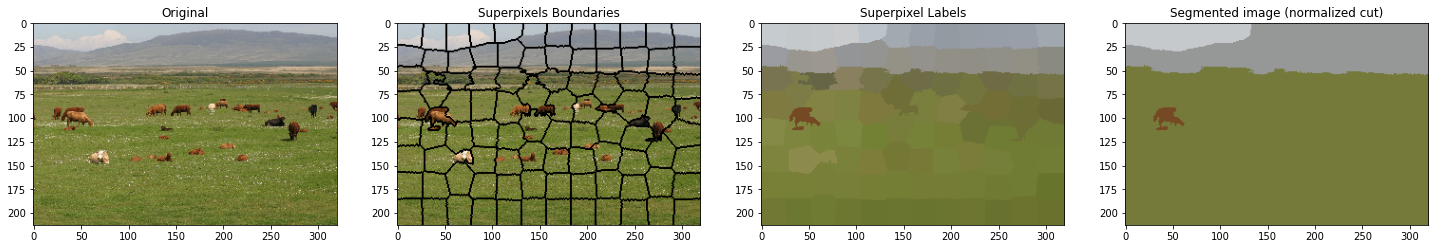

In [11]:
from skimage import data, io, segmentation, color, exposure, transform
from skimage.future import graph
from skimage.util import img_as_ubyte, img_as_float, img_as_uint, img_as_float64
from skimage.metrics import structural_similarity as ssim
import numpy as np

f, axarr = plt.subplots(nrows=1, ncols=4, figsize=(25, 20))

axarr[0].imshow(img_normal)
axarr[0].set_title("Original")

# creating superpixels using k-means
img, labels, pixel_labels = compute_superpixels(img_normal)

#plot boundaries
axarr[1].imshow(img)
axarr[1].set_title("Superpixels Boundaries")

#plot labels
axarr[2].imshow(pixel_labels)
axarr[2].set_title('Superpixel Labels')

#compute segmentation
segmented_image = apply_ncut(img_normal, labels)
axarr[3].imshow(segmented_image)
axarr[3].set_title('Segmented image (normalized cut)')

# Metrics

In this section we define what metrics are used to compare images segmented via ncut and images representing the truth. We will use:


*   SSIM - Structural Similarity index is used as a metric to measure the similarity between two given images.
*   Intersection-Over-Union (IoU) - Given a class, the IoU is the area of overlap between the predicted segmentation class and the ground truth divided by the area of union between the predicted segmentation and the ground truth
* ARI - Adjusted Random Index, this is a measure of similiarity between clusters, we can see the segmented image as the result of a clustering algorithm since we assign a label at each pixel. The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings


To apply these metrics we need that the prediction and the groundtruth image have the same lables. To compute the lables we compute a mask on the groundtruth and on the prediction assigning an id to each color found on the image

Segmentation using ncut however may find more regions than groundtruth, this will lower the accuracy.


In [12]:
def compute_mask(image):
  color_dict = {}

  # Get the shape of the image
  height,width,_ = image.shape

  # Create an empty array for labels
  labels = np.zeros((height,width),dtype=int)
  id=0
  # Loop over each pixel
  for i in range(height):
      for j in range(width):
          # Get the color of the pixel
          color = tuple(image[i,j])
          # Check if it is in the dictionary
          if color in color_dict:
              # Assign the label from the dictionary
              labels[i,j] = color_dict[color]
          else:
              color_dict[color]=id
              labels[i,j] = id
              id+=1
              
  return(labels)

In [26]:
def show_img(prediction, groundtruth):
  f, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

  axarr[0].imshow(groundtruth)
  axarr[0].set_title("groundtruth")
  axarr[1].imshow(prediction)
  axarr[1].set_title(f"prediction")

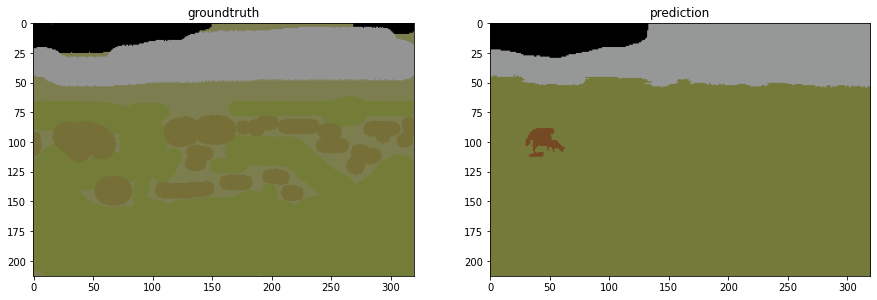

In [14]:
prediction_mask = compute_mask(segmented_image)
groundtruth_mask = compute_mask(img_segmented)

#usign the original image as baseline to convert from labels to color
prediction_img = color.label2rgb(prediction_mask, img_normal, kind='avg', bg_label=0)
groundtruth_img = color.label2rgb(groundtruth_mask, img_normal, kind='avg', bg_label=0)

show_img(prediction_img, groundtruth_img)

Lets now compare the images considering all the accuracy metrics

In [15]:
from skimage.metrics import structural_similarity as ssim

ssim_score = ssim(prediction_img, groundtruth_img, channel_axis=2)
print(f"SSIM SCORE: {ssim_score}")


SSIM SCORE: 0.8597778515286904


In [16]:
from sklearn.metrics import jaccard_score
def iou_score(prediction, truth):
    jac = jaccard_score(y_true=np.asarray(truth).flatten(),
                        y_pred=np.asarray(prediction).flatten(),
                        average = None)
    
    # compute mean IoU score across all classes
    mean_iou = np.mean(jac)
    return mean_iou

In [17]:
iou = iou_score(prediction_mask, groundtruth_mask)
print(f"IOU SCORE: {iou}")

IOU SCORE: 0.16258416592260255


In [18]:
from sklearn.metrics import adjusted_rand_score
import skimage.segmentation as seg

def ari_score(prediction, groundtruth):
  gt_mask = groundtruth.flatten()
  prediction_mask = prediction.flatten()
  
  score = adjusted_rand_score(prediction_mask, gt_mask)
  return score

In [19]:
ari = ari_score(prediction_mask, groundtruth_mask)
print(f"ARI SCORE: {ari}")

ARI SCORE: 0.4217722697421266


# Compute image segmentation and accuracy for all the dataset

In [20]:
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import adapted_rand_error, variation_of_information
# separate segmented and not segmented files
normal_images = [s for s in images_names if "_GT" not in s]
segmented_images = [s for s in images_names if "_GT" in s]

ncut_images = []
accuracies = ["ssim_score", "iou_score", "ari_score"]
columns = ["Name"] + accuracies
results_df = pd.DataFrame(columns=columns)

#compute segmentation
for normal_image, gt, in zip(normal_images, segmented_images):
  # load normal image
  img_normal = load_image(data_path+"/"+normal_image)
  # load groundtruth
  img_gt = load_image(data_path+"/"+gt)

  # creating superpixels and apply ncut
  _, labels, _ = compute_superpixels(img_normal)
  prediction = apply_ncut(img_normal, labels)

  prediction_mask = compute_mask(prediction)
  groundtruth_mask = compute_mask(img_gt)

  groundtruth_img = color.label2rgb(groundtruth_mask, img_normal, kind='avg')
  prediction_img = color.label2rgb(prediction_mask, img_normal, kind='avg')
  
  # compute metrics
  ssim_score = ssim(prediction_img, groundtruth_img, channel_axis=2)
  iou = iou_score(prediction_mask, groundtruth_mask)
  ari = ari_score(prediction_mask, groundtruth_mask)

  # Insert Dict to the dataframe using DataFrame.loc()
  results_df.loc[len(results_df.index)] = [gt,ssim_score,iou, ari]
  

In [21]:
results_df

,Name,ssim_score,iou_score,ari_score
0,1_10_s_GT.bmp,0.859778,0.162584,0.421772
1,1_11_s_GT.bmp,0.715652,0.432217,0.605832
2,1_12_s_GT.bmp,0.717657,0.128410,0.522957
3,1_13_s_GT.bmp,0.114959,0.045690,0.427214
4,1_14_s_GT.bmp,0.123316,0.060467,0.342222
...,...,...,...,...
235,8_5_s_GT.bmp,0.322851,0.004481,0.132032
236,8_6_s_GT.bmp,0.430935,0.026244,0.199841
237,8_7_s_GT.bmp,0.424836,0.043087,0.202111
238,8_8_s_GT.bmp,0.505931,0.033329,0.178313


# Average accuracy results per class

In [22]:
cols = ["Class"] + accuracies
average_accuracy = pd.DataFrame(columns=cols)

#iter on classes
for i in range(1, 9):
  # filter the rows by name and compute the mean of accuracies
  filtered_df = results_df.loc[results_df['Name'].str.startswith(str(i)+'_'), accuracies]
  means = []
  for acc in accuracies:
    means.append(filtered_df[acc].mean())

  new_row = [i]
  for m in means:
    new_row.append(m)
  
  average_accuracy.loc[len(average_accuracy.index)] = new_row
  
average_accuracy

,Class,ssim_score,iou_score,ari_score
0,1.0,0.662958,0.292288,0.465910
1,2.0,0.624121,0.077358,0.405804
2,3.0,0.609701,0.072805,0.321220
3,4.0,0.695281,0.130498,0.588650
4,5.0,0.582206,0.076181,0.407171
5,6.0,0.301141,0.018093,0.101397
6,7.0,0.452610,0.021593,0.220064
7,8.0,0.357962,0.035665,0.136583


As we can see from the average results per class the ssim score is the one that gives the highest results. the accuracy considering the iou is low as many times segmenting the image by ncut finds many more regions than actually exist.

# Example of well segmented images

In [28]:
# sort the dataframe in descending order by ssim score
df_sorted = results_df.sort_values(by='iou_score', ascending=False)

df_sorted.head(15)

,Name,ssim_score,iou_score,ari_score
24,1_4_s_GT.bmp,1.000000,1.000000,1.000000
23,1_3_s_GT.bmp,1.000000,1.000000,1.000000
27,1_7_s_GT.bmp,1.000000,1.000000,1.000000
26,1_6_s_GT.bmp,1.000000,1.000000,1.000000
10,1_1_s_GT.bmp,1.000000,1.000000,1.000000
104,4_23_s_GT.bmp,0.813401,0.512603,0.685187
1,1_11_s_GT.bmp,0.715652,0.432217,0.605832
16,1_25_s_GT.bmp,0.759725,0.423687,0.558016
140,5_29_s_GT.bmp,0.800439,0.380123,0.675990
117,4_7_s_GT.bmp,0.748281,0.368924,0.517867


Since images with accuracy 1 are images of one colour with one class they might be not representative, I choose to display also images with accuracy a little lower than one

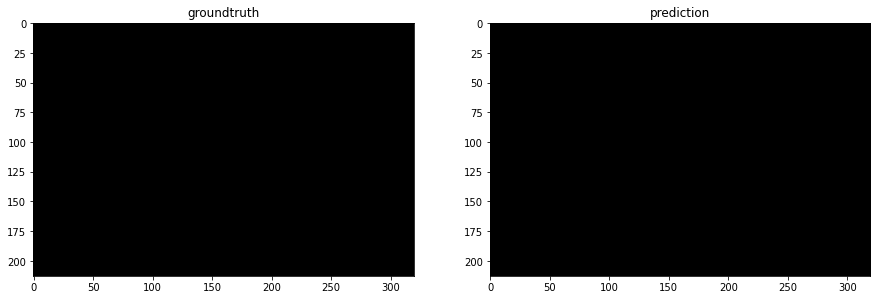

In [27]:
# load normal image
img_normal = load_image(data_path+"/1_1_s_GT.bmp")
# load groundtruth
img_gt = load_image(data_path+"/1_1_s_GT.bmp")

# creating superpixels and apply ncut
_, labels, _ = compute_superpixels(img_normal)
prediction = apply_ncut(img_normal, labels)

prediction_mask = compute_mask(prediction)
groundtruth_mask = compute_mask(img_gt)

groundtruth_img = color.label2rgb(groundtruth_mask, img_normal, kind='avg')
prediction_img = color.label2rgb(prediction_mask, img_normal, kind='avg')
  
show_img(prediction_img, groundtruth_img)

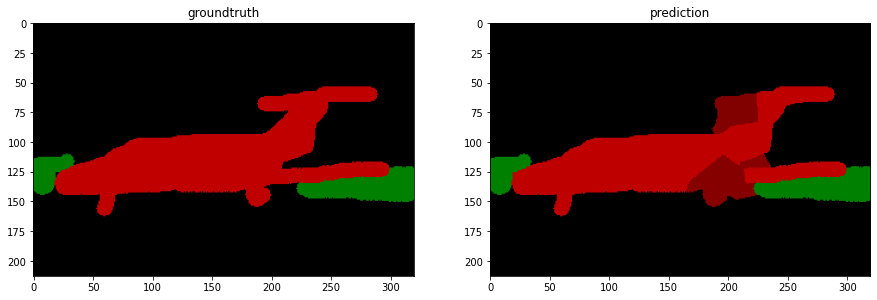

In [29]:
# load normal image
img_normal = load_image(data_path+"/4_23_s_GT.bmp")
# load groundtruth
img_gt = load_image(data_path+"/4_23_s_GT.bmp")

# creating superpixels and apply ncut
_, labels, _ = compute_superpixels(img_normal)
prediction = apply_ncut(img_normal, labels)

prediction_mask = compute_mask(prediction)
groundtruth_mask = compute_mask(img_gt)

groundtruth_img = color.label2rgb(groundtruth_mask, img_normal, kind='avg')
prediction_img = color.label2rgb(prediction_mask, img_normal, kind='avg')
  
show_img(prediction_img, groundtruth_img)

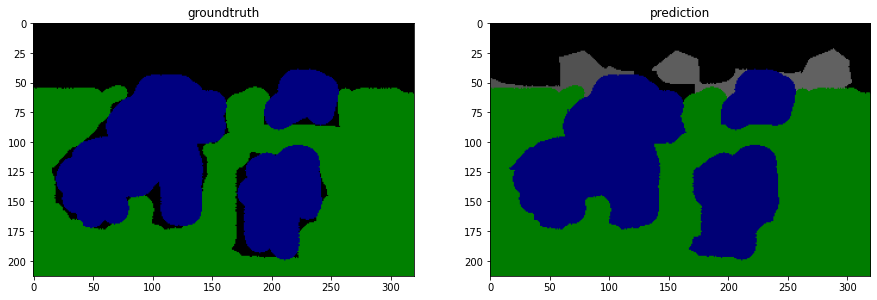

In [31]:
# load normal image
img_normal = load_image(data_path+"/1_11_s_GT.bmp")
# load groundtruth
img_gt = load_image(data_path+"/1_11_s_GT.bmp")

# creating superpixels and apply ncut
_, labels, _ = compute_superpixels(img_normal)
prediction = apply_ncut(img_normal, labels)

prediction_mask = compute_mask(prediction)
groundtruth_mask = compute_mask(img_gt)

groundtruth_img = color.label2rgb(groundtruth_mask, img_normal, kind='avg')
prediction_img = color.label2rgb(prediction_mask, img_normal, kind='avg')
  
show_img(prediction_img, groundtruth_img)

# Personal notes

As we have seen, segmentation is done quite well using ncut. The intersection of union metric is the most reliable metric since we are dealing with a multiclass problem and the class are unbalanced, iou also is the metric that provides the lowest scores. The problem is that the image segmentation using ncut is a unsupervised taks, so the algorithm does not know how many classes there are in an image and may found more classes than the groundtruth.
Furthermore, to further improve segmentation, compactness and segments values should be defined for each image rather than chosen globally for each image as each image has different characteristics